In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import librosa,librosa.display
from wave import open 
import wave
import pickle
from sklearn.preprocessing import  OneHotEncoder

In [ ]:
x ="/content/recording1.wav"
waveFile = open(x,'rb')
nframes = waveFile.getnframes()
wavFrames = waveFile.readframes(nframes)
ys = np.fromstring(wavFrames, dtype=np.int16)
print(ys)

[-5414 -5414 -5416 ... -6755 -5949 -5952]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [ ]:
data_path = pd.DataFrame(ys)
data_path.to_csv("data_path.csv",index=False)
print(data_path)

           0
0      -5414
1      -5414
2      -5416
3      -5414
4      -5414
...      ...
440995 -6755
440996 -6755
440997 -6755
440998 -5949
440999 -5952

[441000 rows x 1 columns]


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

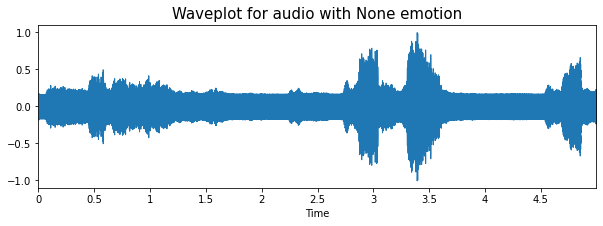

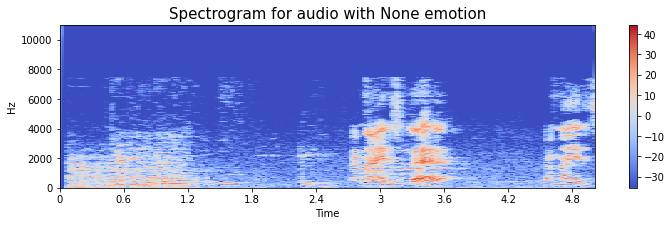

In [ ]:
path = x
data, sampling_rate = librosa.load(x)# feed directly
create_waveplot(data, sampling_rate,e=None)
create_spectrogram(data, sampling_rate,e=None)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


data, sample_rate = librosa.load(path)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X,Y = [], []# create only x
feature = get_features(path)
X.append(feature)
len(X[0])


3

In [ ]:
Features = pd.DataFrame(X[0])
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.009354,0.560415,0.603914,0.573664,0.556130,0.627972,0.645980,0.613784,0.626598,0.533199,...,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000008,0.000012,0.000020,0.000023
1,0.009861,0.706245,0.721457,0.692485,0.720953,0.785783,0.757916,0.668898,0.675115,0.637738,...,0.010469,0.010442,0.010782,0.010753,0.009949,0.010075,0.010700,0.009891,0.010633,0.010994
2,0.001971,0.541321,0.557774,0.561331,0.499911,0.572865,0.630470,0.620597,0.645398,0.532710,...,0.000006,0.000006,0.000006,0.000007,0.000008,0.000010,0.000012,0.000016,0.000024,0.000027


In [ ]:
from keras.models import load_model
model_new = load_model("/content/model2.h5")

In [ ]:
pred_test = model_new.predict(X)
print(pred_test)
len(pred_test)

[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


3

In [ ]:
p1 = pred_test[0]
p2 = pred_test[1]
p3 = pred_test[2]
res_list = []
for i in range(0, 8):
    res_list.append(p1[i] + p2[i]+p3[i])
res_list
Max = max(res_list)
emotion = res_list.index(Max)
for i in range(1):
  if emotion == 0:
    print("The emotion displayed in the played audio is", '\033[95m' + '  SURPRISE' + '\033[0m')
  elif emotion == 1:
    print("The emotion displayed in the played audio is", '\033[95m' + 'DISGUST' + '\033[0m')
  elif emotion == 7:
    print("The emotion displayed in the played audio is", '\033[95m' + 'FEAR' + '\033[0m')
  elif emotion == 3:
    print("The emotion displayed in the played audio is", '\033[95m' + 'SAD' + '\033[0m')
  elif emotion == 4:
    print("The emotion displayed in the played audio is", '\033[95m' + 'CALM' + '\033[0m')
  elif emotion == 5:
    print("The emotion displayed in the played audio is", '\033[95m' + 'HAPPY' + '\033[0m')
  elif emotion == 6:
    print("The emotion displayed in the played audio is", '\033[95m' + 'ANGRY' + '\033[0m')
  else:
    print("The emotion displayed in the played audio is", '\033[95m' + 'NEUTRAL' + '\033[0m')

The emotion displayed in the played audio is ANGRY
